# MASTER - Notebook 4
## Hierarchical clustering with second procedure
### Matteo Grazioso 884055

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime
import json
import os
import folium
import warnings
warnings.filterwarnings('ignore')

import myfunctions as mf # Custom functions

In [3]:
# Disply all columns and all rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

---------


In [4]:
# Open the dataset that has also the geo coordinates
# Find all txt files in the data folder
csv_file = mf.find_csv_files('data/processed/csvPuliti')

print("Select a dataset with geo coordinates from the list:")

# Choose a dataset from the list of txt files
selected_dataset = mf.choose_dataset(csv_file)

if selected_dataset:
    print(f"You selected the dataset {selected_dataset}")
else:
    print("No dataset selected.")

path  = selected_dataset

Select a dataset with geo coordinates from the list:
The following files were found:
1. data/processed/csvPuliti/dataset_cleaned_tempesportazioneCompleta.csv
2. data/processed/csvPuliti/dataset_cleaned_tempesportazioneCompleta_after.csv
3. data/processed/csvPuliti/dataset_cleaned_tempesportazioneCompleta_before.csv
4. data/processed/csvPuliti/dataset_cleaned_tempesportazioneCompleta_during.csv
5. data/processed/csvPuliti/dataset_cleaned_tempesportazionePasqua23_part1.csv
6. data/processed/csvPuliti/dataset_cleaned_tempesportazionePasqua23_part1_after.csv
7. data/processed/csvPuliti/dataset_cleaned_tempesportazionePasqua23_part1_during.csv
8. data/processed/csvPuliti/dataset_cleaned_tempesportazionePasqua23_part2.csv
9. data/processed/csvPuliti/dataset_cleaned_tempvalidazioni.csv
You selected the dataset data/processed/csvPuliti/dataset_cleaned_tempesportazioneCompleta.csv


In [4]:
df = pd.read_csv(path, header=0, sep='\t')

# Save the name of the file in a variable for future use extracting the name of the file from the path
file_name = path.split('/')[3]
file_name = file_name.split('.')[0]

subfolder = file_name
print(f"File name: {file_name}")

# Display the first 5 rows of the dataframe
df.head()

# Convert the column 'DATA' to datetime format
df['DATA'] = pd.to_datetime(df['DATA'], format='%Y-%m-%d')

File name: Carnival


In [5]:
df.head()

,DATA,ORA,DATA_VALIDAZIONE,SERIALE,FERMATA,stop_lat,stop_lon,DESCRIZIONE,TITOLO,TICKET_CODE,DESCRIZIONE_TITOLO
0,2023-01-13,00:00:00,2023-01-13 00:00:00,40834866809772548,-3,45.482675,12.231809,Stazione Mestre,12101,7,BIGL.AUT.75'MESTRE/LIDO-TSC
1,2023-01-13,00:00:00,2023-01-13 00:00:00,-3604990320,5049,45.429260,12.326280,zattere,23301,5-STUD,MENS.STUDENTE RETE UNICA
2,2023-01-13,00:00:00,2023-01-13 00:00:00,-2824230951,5043,45.435184,12.327917,s. toma,23303,6-STUD,ABB STUD. RETEUNICA 12 MESI
3,2023-01-13,00:00:00,2023-01-13 00:00:00,40552750134805252,5013,45.433342,12.342007,"S. Marco-San Zaccaria ""F""",11101,7,"75'-TPL 8,64-COMVE0,86"
4,2023-01-13,00:01:00,2023-01-13 00:01:00,-3604964420,-2,45.438038,12.318223,Piazzale Roma,11209,7,BIGL RETE UNICA 75'


In [6]:
# Print the interval of dates for which we have data
print('Date range: {} to {}'.format(df['DATA'].min(), df['DATA'].max()))

Date range: 2023-01-13 00:00:00 to 2023-03-14 00:00:00


In [7]:
# Rename stop_lat to LONGITUDE and stop_lon to LATITUDE
df.rename(columns={'stop_lat': 'LATITUDE', 'stop_lon': 'LONGITUDE'}, inplace=True)

In [8]:
# For each stop, store the number of use for each ticket code
# Each stop is a point identified by the coordinates (latitude, longitude)

with open('data/dictionaries/dict_ticket_codes.json') as f:
        ticket_codes = json.load(f)

print('The ticket codes are: ', ticket_codes)

# Change 5-STUD, 6-STUD to STUD in the dataframe
df['TICKET_CODE'] = df['TICKET_CODE'].replace(['5-STUD', '6-STUD'], 'STUD')
# Change 5-WKRS, 6-WKRS to WKRS in the dataframe
df['TICKET_CODE'] = df['TICKET_CODE'].replace(['5-WKRS', '6-WKRS'], 'WKRS')
# Change 5-RET, 6-RET to RET in the dataframe
df['TICKET_CODE'] = df['TICKET_CODE'].replace(['5-RET', '6-RET'], 'RET')

# Print the unique ticket codes
# Print information about the changes made
print('The ticket codes 5-STUD and 6-STUD have been changed to STUD')
print('The ticket codes 5-WKRS and 6-WKRS have been changed to WKRS')
print('The ticket codes 5-RET and 6-RET have been changed to RET')

# Convert all the ticket codes to string
df['TICKET_CODE'] = df['TICKET_CODE'].astype(str)

ticket_codes = df['TICKET_CODE'].unique()
# Sort the ticket codes
ticket_codes.sort()

print('The considered ticket codes are: ', ticket_codes)

# For each stop, store the number of visits for each ticket code
# Iterate over the stops dataframe and for each stop, store the number of visits for each ticket code
# Notice that a stop is a pair of coordinates (latitude, longitude)

# The columns of the dataframe are:
# ['DATA', 'ORA', 'DATA_VALIDAZIONE', 'SERIALE', 'FERMATA', 'DESCRIZIONE',
#        'TITOLO', 'TICKET_CODE', 'DESCRIZIONE_TITOLO', 'LATITUDE', 'LONGITUDE']

# Create a dataframe of stops
df_stop = df[['LATITUDE', 'LONGITUDE', 'TICKET_CODE', 'FERMATA', 'DESCRIZIONE']]

df_stop.head()


The ticket codes are:  {'1': 'One-day ticket', '2': 'Two-day ticket', '3': 'Three-day ticket', '4': 'Seven-day ticket', '5': 'Monthly ticket', '5-STUD': 'Monthly ticket for students', '5-RET': 'Monthly ticket for retired', '5-WKRS': 'Monthly ticket for workers', '6': 'Annual ticket', '6-STUD': 'Annual ticket for students', '6-RET': 'Annual ticket for retired', '6-WKRS': 'Annual ticket for workers', '7': '75 minutes ticket', '8': 'Other ticket'}
The ticket codes 5-STUD and 6-STUD have been changed to STUD
The ticket codes 5-WKRS and 6-WKRS have been changed to WKRS
The ticket codes 5-RET and 6-RET have been changed to RET
The considered ticket codes are:  ['1' '2' '3' '4' '5' '6' '7' 'RET' 'STUD' 'WKRS']


,LATITUDE,LONGITUDE,TICKET_CODE,FERMATA,DESCRIZIONE
0,45.482675,12.231809,7,-3,Stazione Mestre
1,45.429260,12.326280,STUD,5049,zattere
2,45.435184,12.327917,STUD,5043,s. toma
3,45.433342,12.342007,7,5013,"S. Marco-San Zaccaria ""F"""
4,45.438038,12.318223,7,-2,Piazzale Roma


In [9]:
df.head()

,DATA,ORA,DATA_VALIDAZIONE,SERIALE,FERMATA,LATITUDE,LONGITUDE,DESCRIZIONE,TITOLO,TICKET_CODE,DESCRIZIONE_TITOLO
0,2023-01-13,00:00:00,2023-01-13 00:00:00,40834866809772548,-3,45.482675,12.231809,Stazione Mestre,12101,7,BIGL.AUT.75'MESTRE/LIDO-TSC
1,2023-01-13,00:00:00,2023-01-13 00:00:00,-3604990320,5049,45.429260,12.326280,zattere,23301,STUD,MENS.STUDENTE RETE UNICA
2,2023-01-13,00:00:00,2023-01-13 00:00:00,-2824230951,5043,45.435184,12.327917,s. toma,23303,STUD,ABB STUD. RETEUNICA 12 MESI
3,2023-01-13,00:00:00,2023-01-13 00:00:00,40552750134805252,5013,45.433342,12.342007,"S. Marco-San Zaccaria ""F""",11101,7,"75'-TPL 8,64-COMVE0,86"
4,2023-01-13,00:01:00,2023-01-13 00:01:00,-3604964420,-2,45.438038,12.318223,Piazzale Roma,11209,7,BIGL RETE UNICA 75'


In [10]:
df_stop_count = df_stop.groupby(['LATITUDE', 'LONGITUDE', 'TICKET_CODE', 'FERMATA', 'DESCRIZIONE']).size().reset_index(name='COUNT')

df_stop_count.head(20)

,LATITUDE,LONGITUDE,TICKET_CODE,FERMATA,DESCRIZIONE,COUNT
0,45.223690,12.280678,1,5072,chioggia,843
1,45.223690,12.280678,2,5072,chioggia,143
2,45.223690,12.280678,3,5072,chioggia,138
3,45.223690,12.280678,4,5072,chioggia,171
4,45.223690,12.280678,5,5072,chioggia,4621
5,45.223690,12.280678,6,5072,chioggia,1276
6,45.223690,12.280678,7,5072,chioggia,8778
7,45.223690,12.280678,RET,5072,chioggia,231
8,45.223690,12.280678,STUD,5072,chioggia,653
9,45.223690,12.280678,WKRS,5072,chioggia,1


In [11]:
# Describe the column COUNT
df_stop_count['COUNT'].describe()

count       968.000000
mean       5111.029959
std       21272.190899
min           1.000000
25%          48.000000
50%         605.500000
75%        3820.500000
max      507765.000000
Name: COUNT, dtype: float64

In [12]:
# Pivot table for the ticket codes but maintaining the information about the stops
df_stop_count = df_stop_count.pivot_table(index=['LATITUDE', 'LONGITUDE', 'FERMATA', 'DESCRIZIONE'], columns='TICKET_CODE', values='COUNT', fill_value=0)
df_stop_count.reset_index(inplace=True)

# For each stop (LATITUDE, LONGITUDE), change the counter of each ticket code as a percentage of the total number of tickets
for row in range(len(df_stop_count)):
    total = df_stop_count.iloc[row, 4:].sum()
    for col in range(4, len(df_stop_count.columns)):
        df_stop_count.iloc[row, col] = df_stop_count.iloc[row, col] / total * 100

In [13]:
df_stop_count

TICKET_CODE,LATITUDE,LONGITUDE,FERMATA,DESCRIZIONE,1,2,3,4,5,6,7,RET,STUD,WKRS
0,45.223690,12.280678,5072,chioggia,5.001483,0.848413,0.818748,1.014536,27.416197,7.570454,52.079502,1.370513,3.874221,0.005933
1,45.243614,12.294001,5017,caroman,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000
2,45.262791,12.299958,5073,pellestrina cimitero m/n,2.559242,0.758294,0.995261,0.568720,19.052133,1.611374,72.559242,0.379147,1.516588,0.000000
3,45.332737,12.316975,5102,s. maria del mare n/t,4.745763,1.694915,0.338983,2.033898,5.423729,4.067797,81.355932,0.000000,0.338983,0.000000
4,45.341526,12.308979,5103,alberoni faro rocchetta n,14.020427,2.321263,0.742804,0.000000,2.692665,7.706592,72.237697,0.185701,0.092851,0.000000
5,45.390778,12.353001,-5,Lido bus,4.701412,4.124782,5.068157,2.496520,8.892473,3.062104,69.690476,0.468374,1.484656,0.011047
6,45.412113,12.359925,5079,s. lazzaro,14.786967,9.774436,5.513784,4.761905,0.501253,0.501253,63.157895,0.000000,1.002506,0.000000
7,45.417358,12.367540,5152,"Lido S.M.E. ""E""",16.666667,0.000000,0.000000,0.000000,0.000000,0.000000,83.333333,0.000000,0.000000,0.000000
8,45.417480,12.367735,5003,"Lido S.M.E. ""D""",4.109332,3.642309,5.700495,2.968763,28.981233,25.396813,19.975593,1.404980,7.748512,0.071970
9,45.417683,12.368217,5002,"Lido S.M.E. ""C""",6.183500,4.090877,5.376649,2.779154,28.883856,17.196310,24.066341,0.485998,8.552150,2.385165


In [14]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def haversine_distance(coord1, coord2):
    """
        Calculate the distance between two points on Earth using the haversine formula.
        The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes.
        The haversin formula is specified as:
            a = sin²(Δlat/2) + cos(lat1).cos(lat2).sin²(Δlong/2)
            c = 2.atan2(√a, √(1−a))
            d = R.c
        where:
            lat1, long1 = Latitude and Longitude of point 1 (in decimal degrees)
            lat2, long2 = Latitude and Longitude of point 2 (in decimal degrees)
            R = Radius of the Earth in kilometers
            Δlat = lat2− lat1
            Δlong = long2− long1

        :param coord1: Tuple of (latitude, longitude) for point 1
        :param coord2: Tuple of (latitude, longitude) for point 2
        :return: Distance between the two coordinates in kilometers
    """
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    
    R = 6371  # Radius of the Earth in kilometers
    
    # Convert decimal degrees to radians
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    
    # Apply haversine formula
    # a = sin²(Δlat/2) + cos(lat1).cos(lat2).sin²(Δlong/2)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2

    # c = 2.atan2(√a, √(1−a))
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # d = R.c
    distance = R * c

    return distance

def cosine_similarity_distance(counts1, counts2):
    # Calculate cosine similarity between two count vectors
    """
        Calculate the cosine similarity between two count vectors.
        The cosine similarity is a measure of similarity between two non-zero vectors of an inner product space 
        that measures the cosine of the angle between them.
        The cosine of 0° is 1, and it is less than 1 for any other angle.
        It is thus a judgement of orientation and not magnitude: two vectors with the same orientation have a cosine similarity of 1,
        two vectors at 90° have a similarity of 0, and two vectors diametrically opposed have a similarity of -1, independent of their magnitude.
        The cosine similarity is particularly used in positive space, where the outcome is neatly bounded in [0,1].
        The cosine similarity is mathematically defined as:
            cos(θ) = A.B / ||A||.||B||
        where:
            A.B = Dot product of A and B
            ||A|| = Euclidean norm of A
            ||B|| = Euclidean norm of B
        :param counts1: List of counts for each ticket code for stop 1
        :param counts2: List of counts for each ticket code for stop 2
        :return: Cosine similarity between the two count vectors

        # This function calls the cosine_similarity function from sklearn.metrics.pairwise to calculate the cosine similarity between two count vectors.
    """
    similarity_matrix = cosine_similarity([counts1], [counts2])
    similarity = 1 - similarity_matrix[0][0]
    
    return similarity

def custom_distance(stop1, stop2, coord_weight, similarity_weight):
    """
        Calculate the custom distance between two stops.
        The custom distance is a weighted combination of the haversine distance between the two stops and the cosine similarity between the two stops.
        The custom distance is mathematically defined as:
            custom_distance = coord_weight * haversine_distance + similarity_weight * cosine_similarity_distance
        where:
            coord_weight = Weight for haversine distance
            similarity_weight = Weight for cosine similarity distance
        :param stop1: Tuple of (latitude, longitude, counts for each ticket code) for stop 1
        :param stop2: Tuple of (latitude, longitude, counts for each ticket code) for stop 2
        :param coord_weight: Weight for haversine distance
        :param similarity_weight: Weight for cosine similarity distance
        :return: Custom distance between the two stops
    """
    # Calculate distances
    # Calculate haversine distance between two stops
    coord_distance = haversine_distance((stop1[0], stop1[1]), (stop2[0], stop2[1]))
    # Calculate cosine similarity between two stops
    count_similarity = cosine_similarity_distance(stop1[4:], stop2[4:]) # CAMBIATO PERCHÉ NON C'È LA COLONNA 'FERMATA' e 'DESCRIZIONE'
    
    # Combine distances with appropriate weights
    combined_distance = coord_weight * coord_distance + similarity_weight * count_similarity
    return combined_distance

In [15]:
# From df_stop_count remove descrizione
df_stop_count = df_stop_count.drop(columns=['DESCRIZIONE'])

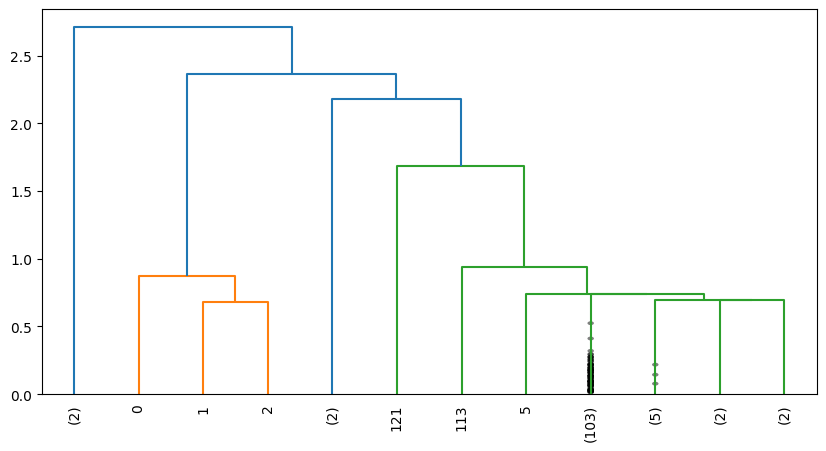

In [16]:
data = df_stop_count.values 

# Custom distance function parameters
coord_weight = 0.3
similarity_weight = 0.7

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Calculate linkage matrix using custom distance function
# The custom distance function is a weighted average of the haversine distance between coordinates and the similarity between the stop counts
linkage_matrix = linkage(data, method='single', metric=lambda x, y: custom_distance(x, y, coord_weight, similarity_weight))

# Create a dendrogram for visualization purposes 
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=10., show_contracted=True)

# Determine clusters based on a desired threshold or number of clusters
threshold = 0.25
clusters = fcluster(linkage_matrix, t=threshold, criterion='distance', depth=2, R=None, monocrit=None)

In [17]:
# Adding cluster labels to the stop count dataframe
df_stop_count['Cluster'] = clusters
print(df_stop_count.shape)
df_stop_count.head()

(122, 14)


TICKET_CODE,LATITUDE,LONGITUDE,FERMATA,1,2,3,4,5,6,7,RET,STUD,WKRS,Cluster
0,45.223690,12.280678,5072,5.001483,0.848413,0.818748,1.014536,27.416197,7.570454,52.079502,1.370513,3.874221,0.005933,5
1,45.243614,12.294001,5017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,3
2,45.262791,12.299958,5073,2.559242,0.758294,0.995261,0.568720,19.052133,1.611374,72.559242,0.379147,1.516588,0.000000,4
3,45.332737,12.316975,5102,4.745763,1.694915,0.338983,2.033898,5.423729,4.067797,81.355932,0.000000,0.338983,0.000000,6
4,45.341526,12.308979,5103,14.020427,2.321263,0.742804,0.000000,2.692665,7.706592,72.237697,0.185701,0.092851,0.000000,7


In [18]:
# get hex codes of tab_20 palette in the format 1:hex_code dict
cluster_colors = dict(zip(range(1,51), sns.color_palette("tab20", 50).as_hex()))

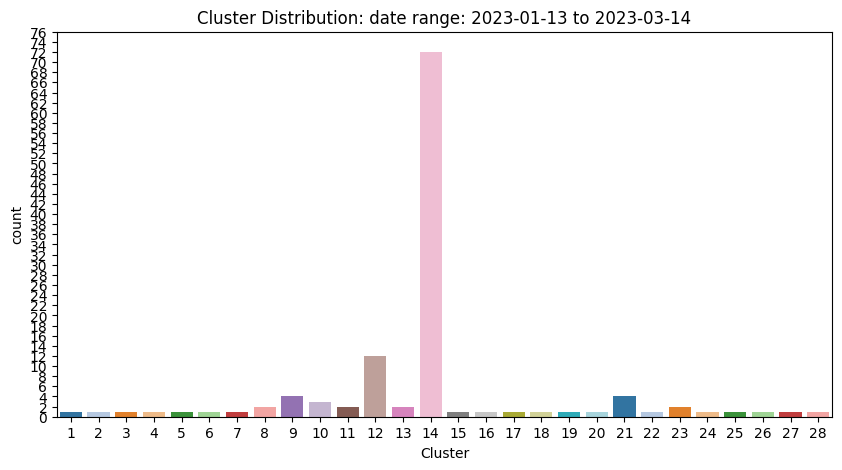

In [19]:
# Countplot of cluster distribution 
fig = plt.figure(figsize=(10, 5))
sns.countplot(x='Cluster', data=df_stop_count, palette=cluster_colors)
plt.yticks(np.arange(0, max(df_stop_count['Cluster'].value_counts()) + 5, 2))
plt.title('Cluster Distribution: ' + 'date range: ' + str(df['DATA'].min().date()) + ' to ' + str(df['DATA'].max().date()))
plt.show()

In [20]:
# Create a folium map centered around the mean latitude and longitude
center_lat = np.mean(df_stop_count['LATITUDE'])
center_lon = np.mean(df_stop_count['LONGITUDE'])
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Create markers for each stop and color them based on clusters
for idx, row in df_stop_count.iterrows():
    # Retrieve Cluster id and set it as a integer
    cluster = int(row['Cluster'])

    cluster_color = cluster_colors.get(cluster, 'gray')  # Default to gray if cluster color is not defined

    # cluster_color = cluster_
    # colors.get(cluster, 'gray')  # Default to gray if cluster color is not defined
    # Add a label to the marker with the name of the stop contained in the column 'DESCRIZIONE'
    # Retrieve the name of the stop from the column 'DESCRIZIONE' of the dataframe df matching the FERMATA
    location = df[df['FERMATA'] == row['FERMATA']]['DESCRIZIONE'].values[0]
    # Retrieve FERMATA id and set it as a integer
    fermata = int(row['FERMATA'])
    # Retrieve Cluster id and set it as a integer
    cluster = int(row['Cluster'])

    # Create a string for popup message containing the name of the stop, FERMATA and the cluster in BOLD
    popup_message = f"<b><i>{location}</i></b><br><br><u>Fermata:</u> {fermata}<br><u>Cluster:</u> {cluster}"

    # Add a marker to the map with the popup message and the color of the cluster
    # folium.Marker(location=[row['LATITUDE'], row['LONGITUDE']], popup=popup_message, icon=folium.Icon(color=cluster_color)).add_to(m)
    if fermata < 0:
        folium.Marker(location=[row['LATITUDE'], row['LONGITUDE']], popup=popup_message, icon=folium.Icon(color='white', icon_color=cluster_color, icon='bus', prefix='fa')).add_to(m)
    else:
        folium.Marker(location=[row['LATITUDE'], row['LONGITUDE']], popup=popup_message, icon=folium.Icon(color='white', icon_color=cluster_color, icon='ship', prefix='fa')).add_to(m)

m

In [21]:
# print the number of unique values of the column 'FERMATA'
print('Number of unique values of the column FERMATA: {}'.format(df['FERMATA'].nunique()))
# print the numer of clusters
print('Number of clusters: {}'.format(df_stop_count['Cluster'].nunique()))
# Print the average number of stops per cluster
print('Average number of stops per cluster: {}'.format(df_stop_count['Cluster'].value_counts().mean()))


Number of unique values of the column FERMATA: 122
Number of clusters: 28
Average number of stops per cluster: 4.357142857142857


In [22]:
# For each Cluster id, print the number of stops in that cluster, the FERMATA id and the name of the stop
df_stop_count_copy = df_stop_count.copy()
# To df_stop_count add a column with the name of the stop matching the FERMATA
df_stop_count_copy['DESCRIZIONE'] = df_stop_count_copy['FERMATA'].apply(lambda x: df[df['FERMATA'] == x]['DESCRIZIONE'].values[0])

# Consider only the columns ['Cluster', 'FERMATA', 'DESCRIZIONE']
df_stop_count_copy = df_stop_count_copy[['Cluster', 'FERMATA', 'DESCRIZIONE']]
df_stop_count_copy.columns.name = None
df_stop_count_copy.head()

print('Number of clusters: ', max(df_stop_count_copy['Cluster']))
print('\n')
for cluster in range(1, max(df_stop_count_copy['Cluster']) + 1):
    print(f"Cluster {cluster} contains {len(df_stop_count_copy[df_stop_count_copy['Cluster'] == cluster])} stops.")
    print(df_stop_count_copy[df_stop_count_copy['Cluster'] == cluster][['FERMATA', 'DESCRIZIONE']])
    print('\n')



Number of clusters:  28


Cluster 1 contains 1 stops.
     FERMATA      DESCRIZIONE
114       -3  Stazione Mestre


Cluster 2 contains 1 stops.
     FERMATA DESCRIZIONE
119       -1       TERRA


Cluster 3 contains 1 stops.
   FERMATA DESCRIZIONE
1     5017     caroman


Cluster 4 contains 1 stops.
   FERMATA               DESCRIZIONE
2     5073  pellestrina cimitero m/n


Cluster 5 contains 1 stops.
   FERMATA DESCRIZIONE
0     5072    chioggia


Cluster 6 contains 1 stops.
   FERMATA            DESCRIZIONE
3     5102  s. maria del mare n/t


Cluster 7 contains 1 stops.
   FERMATA                DESCRIZIONE
4     5103  alberoni faro rocchetta n


Cluster 8 contains 2 stops.
    FERMATA      DESCRIZIONE
7      5152  Lido S.M.E. "E"
10     5158  Lido S.M.E. "C"


Cluster 9 contains 4 stops.
    FERMATA      DESCRIZIONE
8      5003  Lido S.M.E. "D"
9      5002  Lido S.M.E. "C"
11     5001             lido
12     5094  Lido S.M.E. "A"


Cluster 10 contains 3 stops.
    FERMATA       DESCR

In [23]:
# Export the map to an HTML file
# Import the necessary libraries
from datetime import datetime
time = datetime.now().strftime("%Y%m%d-%H%M%S")
try:
    m.save('map/' + file_name + '_clustered_' + time + '.html')
    print('Map saved in map/' + file_name + '/' + file_name + '_clustered_' + time + '.html')
except:
    # Create a new folder in map folder
    os.mkdir('map/' + file_name)
    m.save('map/' + file_name + '/' + file_name + '_clustered_' + time + '.html')
    print('Map saved in map/' + file_name + '/' + file_name + '_clustered_' + time + '.html')

Map saved in map/Carnival/Carnival_clustered_20230904-185758.html


### Apply hierarchical clustering to the data of the main island of Venice (the most populated cluster)

In [24]:
# Select only the data of the main island of Venice (the cluster most populated)
cluster_main_island = df_stop_count['Cluster'].value_counts().index[0]

print('The cluster with the highest number of stops is the cluster number', cluster_main_island)

cluster_main_island = df_stop_count[df_stop_count['Cluster'] == cluster_main_island]


The cluster with the highest number of stops is the cluster number 14


In [25]:
cluster_main_island

TICKET_CODE,LATITUDE,LONGITUDE,FERMATA,1,2,3,4,5,6,7,RET,STUD,WKRS,Cluster
14,45.425320,12.360782,5004,5.625000,1.875000,1.250000,0.000000,0.000000,0.000000,90.000000,0.000000,1.250000,0.000000,14
15,45.425426,12.360565,5005,3.875731,3.851859,5.790578,3.050454,27.126707,24.038740,22.756492,1.756271,7.725885,0.027282,14
16,45.425579,12.332047,5082,9.900990,8.441897,14.226159,9.452840,6.545076,1.365294,47.451798,0.291819,2.324127,0.000000,14
18,45.426624,12.337678,5118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,14
19,45.426720,12.337905,5081,12.391094,13.966871,21.420888,8.190814,5.808325,1.263849,34.053996,0.441002,2.463160,0.000000,14
20,45.426849,12.325638,5022,4.725186,5.069421,7.005164,3.989673,22.671256,14.823867,32.835341,1.191050,7.674125,0.014917,14
21,45.426899,12.325401,5129,6.896552,0.000000,1.724138,0.000000,6.896552,5.172414,75.862069,0.000000,3.448276,0.000000,14
22,45.428310,12.331958,5159,7.110439,7.715582,12.178517,7.866868,5.219365,3.101362,48.562784,0.226929,8.018154,0.000000,14
23,45.428886,12.356096,5128,11.658031,3.108808,1.036269,0.777202,1.813472,0.259067,80.829016,0.000000,0.518135,0.000000,14
24,45.428959,12.316327,5139,3.602906,3.292978,4.648910,2.537530,8.096852,1.888620,70.033898,1.646489,4.251816,0.000000,14


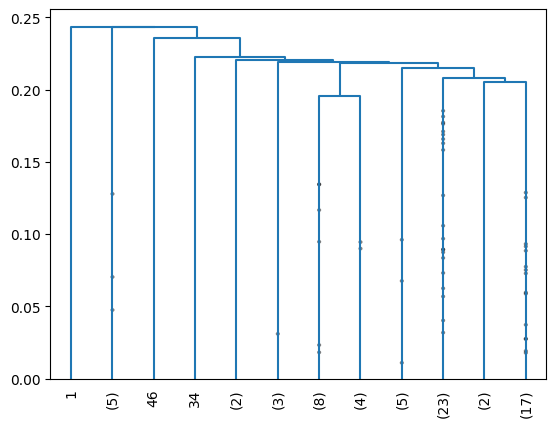

In [26]:
# Apply hierarchical clustering to the data of the main island of Venice (the most populated one)

data = cluster_main_island.values

# Custom distance function parameters
coord_weight = 0.3
similarity_weight = 0.7

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Calculate linkage matrix using custom distance function
# The custom distance function is a weighted average of the haversine distance between coordinates and the similarity between the stop counts
linkage_matrix = linkage(data, method='single', metric=lambda x, y: custom_distance(x, y, coord_weight, similarity_weight))

# Create a dendrogram for visualization purposes 
dendrogram(linkage_matrix, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=10., show_contracted=True)

# Determine clusters based on a desired threshold or number of clusters
threshold = 0.3
clusters = fcluster(linkage_matrix, t=threshold, criterion='distance', depth=2, R=None, monocrit=None)


In [27]:
cluster_main_island

TICKET_CODE,LATITUDE,LONGITUDE,FERMATA,1,2,3,4,5,6,7,RET,STUD,WKRS,Cluster
14,45.425320,12.360782,5004,5.625000,1.875000,1.250000,0.000000,0.000000,0.000000,90.000000,0.000000,1.250000,0.000000,14
15,45.425426,12.360565,5005,3.875731,3.851859,5.790578,3.050454,27.126707,24.038740,22.756492,1.756271,7.725885,0.027282,14
16,45.425579,12.332047,5082,9.900990,8.441897,14.226159,9.452840,6.545076,1.365294,47.451798,0.291819,2.324127,0.000000,14
18,45.426624,12.337678,5118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,14
19,45.426720,12.337905,5081,12.391094,13.966871,21.420888,8.190814,5.808325,1.263849,34.053996,0.441002,2.463160,0.000000,14
20,45.426849,12.325638,5022,4.725186,5.069421,7.005164,3.989673,22.671256,14.823867,32.835341,1.191050,7.674125,0.014917,14
21,45.426899,12.325401,5129,6.896552,0.000000,1.724138,0.000000,6.896552,5.172414,75.862069,0.000000,3.448276,0.000000,14
22,45.428310,12.331958,5159,7.110439,7.715582,12.178517,7.866868,5.219365,3.101362,48.562784,0.226929,8.018154,0.000000,14
23,45.428886,12.356096,5128,11.658031,3.108808,1.036269,0.777202,1.813472,0.259067,80.829016,0.000000,0.518135,0.000000,14
24,45.428959,12.316327,5139,3.602906,3.292978,4.648910,2.537530,8.096852,1.888620,70.033898,1.646489,4.251816,0.000000,14


In [28]:
cluster_main_island['Cluster'] = clusters


In [29]:
# Create a folium map centered around the mean latitude and longitude
center_lat = np.mean(cluster_main_island['LATITUDE'])
center_lon = np.mean(cluster_main_island['LONGITUDE'])
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Create markers for each stop and color them based on clusters
for idx, row in cluster_main_island.iterrows():
    # Retrieve Cluster id and set it as a integer
    cluster = int(row['Cluster'])

    cluster_color = cluster_colors.get(cluster, 'gray')  # Default to gray if cluster color is not defined

    # cluster_color = cluster_
    # colors.get(cluster, 'gray')  # Default to gray if cluster color is not defined
    # Add a label to the marker with the name of the stop contained in the column 'DESCRIZIONE'
    # Retrieve the name of the stop from the column 'DESCRIZIONE' of the dataframe df matching the FERMATA
    location = df[df['FERMATA'] == row['FERMATA']]['DESCRIZIONE'].values[0]
    # Retrieve FERMATA id and set it as a integer
    fermata = int(row['FERMATA'])
    # Retrieve Cluster id and set it as a integer
    cluster = int(row['Cluster'])

    # Create a string for popup message containing the name of the stop, FERMATA and the cluster in BOLD
    popup_message = f"<b><i>{location}</i></b><br><br><u>Fermata:</u> {fermata}<br><u>Cluster:</u> {cluster}"

    # Add a marker to the map with the popup message and the color of the cluster
    # folium.Marker(location=[row['LATITUDE'], row['LONGITUDE']], popup=popup_message, icon=folium.Icon(color=cluster_color)).add_to(m)
    if fermata < 0:
        folium.Marker(location=[row['LATITUDE'], row['LONGITUDE']], popup=popup_message, icon=folium.Icon(color='white', icon_color=cluster_color, icon='bus', prefix='fa')).add_to(m)
    else:
        folium.Marker(location=[row['LATITUDE'], row['LONGITUDE']], popup=popup_message, icon=folium.Icon(color='white', icon_color=cluster_color, icon='ship', prefix='fa')).add_to(m)



m